# ENSO schematic figure
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Read in dependencies

In [73]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.io import loadmat
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from scipy import signal
import matplotlib.colors as colors
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

Set data location

In [30]:
loc_tas = "~/" # change if using raw data
loc_nino34 = "../Data/ENSO_Indices/"
loc_composites = "../Data/Example_Composites/"

Set models list, experiments, colors, etc.

In [3]:
ex = ['CCSM3 abrupt 2x','CCSM3 abrupt 4x','CCSM3 abrupt 8x', \
    'CESM1.0.4 abrupt 2x','CESM1.0.4 abrupt 4x','CESM1.0.4 abrupt 8x', \
    'GFDL-CM3 1pct 2x','GFDL-ESM-2M 1pct 2x','GISS-E2-R 1pct 4x', \
    'GISS-E2-R abrupt 4x','HadCM3L abrupt 2x','HadCM3L abrupt 4x', \
    'HadCM3L abrupt 6x','HadCM3L abrupt 8x','IPSL-CM5A abrupt 4x', \
    'MIROC3.2 1pct 2x','MIROC3.2 1pct 4x','MPI-ESM-1.2 abrupt 2x', \
    'MPI-ESM-1.2 abrupt 4x','MPI-ESM-1.2 abrupt 8x']

ex1 = ['CCSM3_abrupt2x','CCSM3_abrupt4x','CCSM3_abrupt8x', \
    'CESM1-0-4_abrupt2x','CESM1-0-4_abrupt4x','CESM1-0-4_abrupt8x', \
    'GFDL-CM3_1pct2x','GFDL-ESM-2M_1pct2x','GISS-E2R_1pct4x', \
    'GISS-E2R_abrupt4x','HadCM3L_abrupt2x','HadCM3L_abrupt4x', \
    'HadCM3L_abrupt6x','HadCM3L_abrupt8x','IPSL_abrupt4x', \
    'MIROC_1pct2x','MIROC_1pct4x','MPI-ESM-12_abrupt2x', \
    'MPI-ESM-12_abrupt4x','MPI-ESM-12_abrupt8x']

runtype = ['abrupt','abrupt','abrupt','abrupt','abrupt','abrupt','lin','lin','lin', \
            'abrupt','abrupt','abrupt','abrupt','abrupt','abrupt', \
            'lin','lin','abrupt','abrupt','abrupt']

Write function for hiding top and right axes

In [4]:
def hide_right_and_top(axis):
    
    # This function hides the right and top axes
    # of a given axis object
    # For purely aesthetic purposes
    
    # Hide the right and top spines
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    axis.yaxis.set_ticks_position('left')
    axis.xaxis.set_ticks_position('bottom')

Detrending function

In [6]:
def custom_detrend_3d(data,order):
    
    # numpy required
    # removes trend of order "order" from the first axis of 3-d data
    
    new_data = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    
    x = np.arange(1,(data.shape[0])+1,1)
    
    dim1 = data.shape[1]
    dim2 = data.shape[2]
    
    for jj in np.arange(0,dim1,1):
        for kk in np.arange(0,dim2,1):
            subset = data[:,jj,kk]
            model = np.polyfit(x,subset,order)
            predicted = np.polyval(model,x)
            new_data[:,jj,kk] = subset - predicted
            
    return(new_data)

#### Analysis
First read in example timeseries

In [15]:
example = "GISSE2R_abrupt4x"
model, exp = example.split("_")
nino34_f = xr.open_dataarray(loc_nino34+"nino34_"+model+"_"+exp+"_raw.nc")
rm_f = 120

nino34_smooth = ((pd.Series(nino34_f.values).rolling(window=rm_f,min_periods=1,center=True).mean()).values)

example2 = "GISSE2R_1pct4x"
model2, exp2 = example2.split("_")
nino34_f2 = xr.open_dataarray(loc_nino34+"nino34_"+model2+"_"+exp2+"_raw.nc")
nino34_smooth2 = ((pd.Series(nino34_f2.values).rolling(window=rm_f,min_periods=1,center=True).mean()).values)

Now read in the actual data for maps

In [34]:
calculate = False # false if not using raw data

In [35]:
lonmin = 140
lonmax = 280
latmin = -15
latmax = 15
latctr = ((latmax-latmin)/2) + latmin
lonctr = ((lonmax-lonmin)/2) + lonmin

ordr = 2
example_model = "GISSE2R_abrupt4x"
model, exp = example_model.split("_")
    
if calculate:
    
    # tas
    fname_exp_start = "tas_mon_"+example_model
    fname_control_start = "tas_mon_"+model+"_control"
    fname_exp = [f for f in os.listdir(loc_tas) if f.startswith(fname_exp_start)][0]
    fname_control = [f for f in os.listdir(loc_tas) if f.startswith(fname_control_start)][0]
    
    tas_exp_global = xr.DataArray(xr.open_dataset(loc_tas+fname_exp).data_vars["tas"])
    tas_control_global = xr.DataArray(xr.open_dataset(loc_tas+fname_control).data_vars["tas"])
    lat_tas = tas_exp_global.coords["lat"]
    lon_tas = tas_exp_global.coords["lon"]
    
    if lat_tas[0] > lat_tas[10]:
        pacific_temps_f = tas_exp_global.loc[:,latmax:latmin,lonmin:lonmax]
        pacific_temps_c = tas_control_global.loc[:,latmax:latmin,lonmin:lonmax]
    else:
        pacific_temps_f = tas_exp_global.loc[:,latmin:latmax,lonmin:lonmax]
        pacific_temps_c = tas_control_global.loc[:,latmin:latmax,lonmin:lonmax]
    lat = pacific_temps_f.coords["lat"]
    lon = pacific_temps_f.coords["lon"]
    
    # nino34
    nino34_f = xr.open_dataarray(loc_nino34+"nino34_"+model+"_"+exp+"_anom_detrend"+str(ordr)+".nc")
    nino34_c = xr.open_dataarray(loc_nino34+"nino34_"+model+"_control_anom_detrend"+str(ordr)+".nc")
    
    # assign time array
    n_months_c = pacific_temps_c.shape[0]
    n_months_f = pacific_temps_f.shape[0]
    
    time_ctrl = xr.cftime_range(start='0001', periods=n_months_c, freq='M')
    time_forced = xr.cftime_range(start='0001', periods=n_months_f, freq='M')
    
    pacific_temps_c_xr = xr.DataArray(pacific_temps_c.values,coords=[time_ctrl,lat,lon],dims=["time","lat","lon"])
    pacific_temps_f_xr = xr.DataArray(pacific_temps_f.values,coords=[time_forced,lat,lon],dims=["time","lat","lon"])
    
    print("detrending and calculating anomalies")
    
    pacific_ctrl_detrend = xr.DataArray(custom_detrend_3d(pacific_temps_c_xr,ordr),coords=[pacific_temps_c_xr.coords["time"],lat,lon],dims=["time","lat","lon"])
    pacific_ctrl_anom = pacific_ctrl_detrend.groupby("time.month") - (pacific_ctrl_detrend.groupby("time.month").mean(dim="time"))
    
    if "abrupt" in exp:
        
        # calculate anomalies by splitting into fast/transient/equilibrium periods, detrend, find anomalies, re-concatenate
        pacific_fast = pacific_temps_f_xr[0:(50*12),:,:]
        pacific_transient = pacific_temps_f_xr[(50*12):(150*12),:,:]
        pacific_eq = pacific_temps_f_xr[(150*12):,:,:]

        pacific_fast_detrend = xr.DataArray(custom_detrend_3d(pacific_fast,ordr),coords=[pacific_fast.coords["time"],lat,lon],dims=["time","lat","lon"])
        pacific_fast_anom = pacific_fast_detrend.groupby("time.month") - (pacific_fast_detrend.groupby("time.month").mean(dim="time"))

        pacific_transient_detrend = xr.DataArray(custom_detrend_3d(pacific_transient,ordr),coords=[pacific_transient.coords["time"],lat,lon],dims=["time","lat","lon"])
        pacific_transient_anom = pacific_transient_detrend.groupby("time.month") - (pacific_transient_detrend.groupby("time.month").mean(dim="time"))

        pacific_eq_detrend = xr.DataArray(custom_detrend_3d(pacific_eq,ordr),coords=[pacific_eq.coords["time"],lat,lon],dims=["time","lat","lon"])
        pacific_eq_anom = pacific_eq_detrend.groupby("time.month") - (pacific_eq_detrend.groupby("time.month").mean(dim="time"))

        pacific_forced_anom = xr.concat([pacific_fast_anom,pacific_transient_anom,pacific_eq_anom],dim="time")
        
    else:
        
        # calculate anomalies by splitting into transient/equilibrium periods, detrend, find anomalies, re-concatenate
        pacific_transient = pacific_temps_f_xr[0:(140*12),:,:]
        pacific_eq = pacific_temps_f_xr[(140*12):,:,:]
        
        pacific_transient_detrend = xr.DataArray(custom_detrend_3d(pacific_transient,ordr),coords=[pacific_transient.coords["time"],lat,lon],dims=["time","lat","lon"])
        pacific_transient_anom = pacific_transient_detrend.groupby("time.month") - (pacific_transient_detrend.groupby("time.month").mean(dim="time"))

        pacific_eq_detrend = xr.DataArray(custom_detrend_3d(pacific_eq,ordr),coords=[pacific_eq.coords["time"],lat,lon],dims=["time","lat","lon"])
        pacific_eq_anom = pacific_eq_detrend.groupby("time.month") - (pacific_eq_detrend.groupby("time.month").mean(dim="time"))

        pacific_forced_anom = xr.concat([pacific_transient_anom,pacific_eq_anom],dim="time")
    
    print("Calculating composites...")    
    
    # Calculate 75th/90th percentiles
    nino34_75_f = np.percentile(nino34_f.values,75)
    nino34_90_f = np.percentile(nino34_f.values,90)
    nino34_75_c = np.percentile(nino34_c.values,75)
    nino34_90_c = np.percentile(nino34_c.values,90)
    
    # Calculate composites
    example_composite_f = pacific_forced_anom[((nino34_f.values >= nino34_75_f) & (nino34_f.values <= nino34_90_f)),:,:].mean(dim="time")
    example_composite_c = pacific_ctrl_anom[((nino34_c.values >= nino34_75_c) & (nino34_c.values <= nino34_90_c)),:,:].mean(dim="time")
    
    # Write out data
    example_composite_f.name = "composite"
    example_composite_f.attrs["creation_date"] = str(datetime.datetime.now())
    example_composite_f.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
    example_composite_f.attrs["created_from"] = "Fig1.ipynb"
    fname_out_exp = loc_composites+"example_elnino_composite_"+model+"_"+exp+".nc"
    example_composite_f.to_netcdf(fname_out_exp,mode="w")
    print(fname_out_exp)
    
    example_composite_c.name = "composite"
    example_composite_c.attrs["creation_date"] = str(datetime.datetime.now())
    example_composite_c.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
    example_composite_c.attrs["created_from"] = "Fig1.ipynb"
    fname_out_control = loc_composites+"example_elnino_composite_"+model+"_control.nc"
    example_composite_c.to_netcdf(fname_out_control,mode="w")
    print(fname_out_control)

else:
    
    example_composite_f = xr.open_dataarray(loc_composites+"example_elnino_composite_"+model+"_"+exp+".nc")
    example_composite_c = xr.open_dataarray(loc_composites+"example_elnino_composite_"+model+"_control.nc")

Example control timeseries

In [21]:
example_timeseries = "GISSE2R_control"
model, exp = example_timeseries.split("_")
nino34_c = xr.open_dataarray(loc_nino34+"nino34_"+model+"_"+exp+"_anom_detrend2.nc")
nino34_schematic = nino34_c[0:50*12]

#### Plot

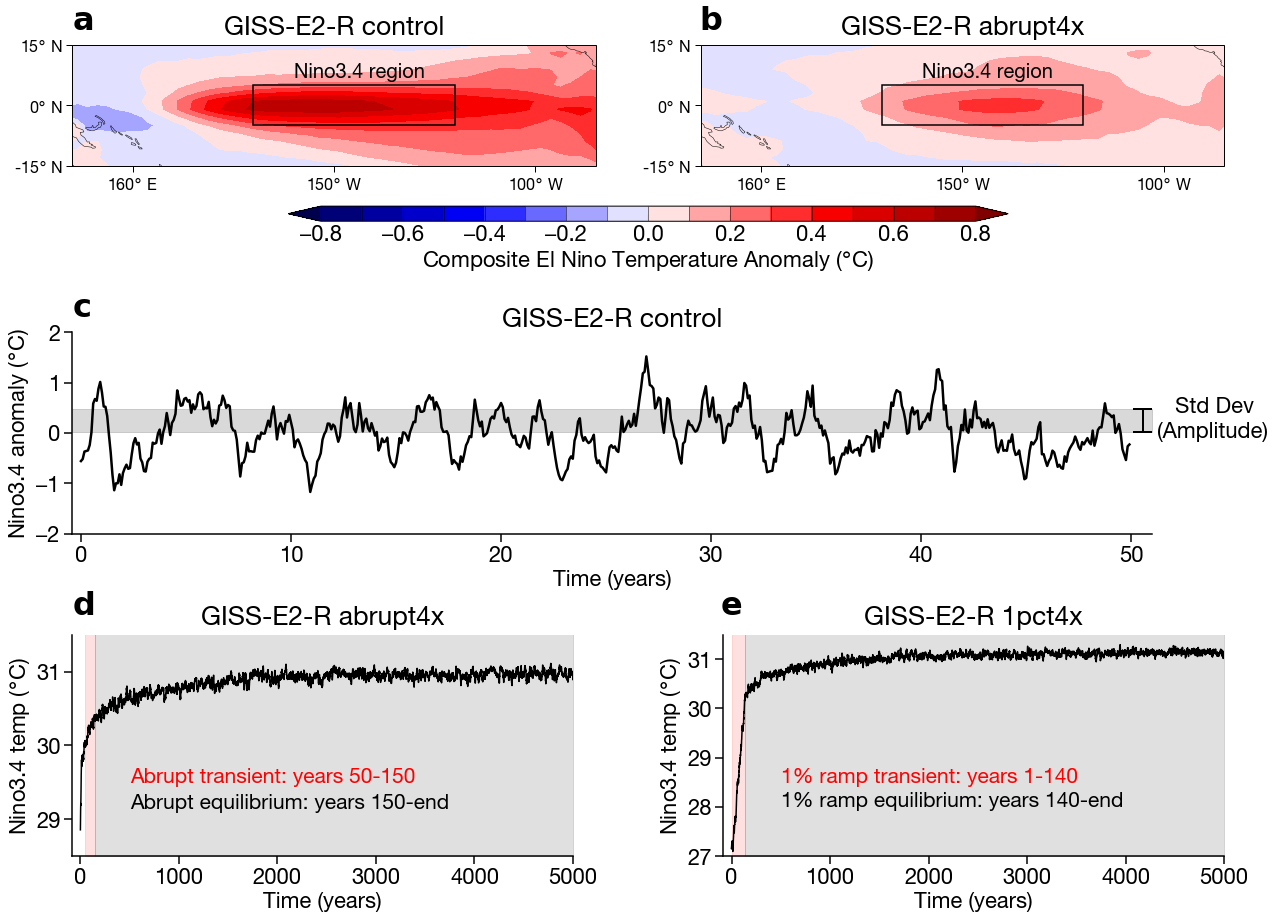

In [96]:
fig = plt.figure(figsize=(20,14))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 22.0
rcParams["axes.linewidth"] = 1.5
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.5


## Timeseries

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.1,right=0.85,top=0.64,bottom=0.44,wspace=0.3,hspace=0.3)

ax = plt.subplot(gs1[0,0])
hide_right_and_top(ax)

p1 = plt.plot(nino34_schematic,color="k",linewidth=2.5)
ax.fill_between([-5,12*51],np.mean(nino34_schematic),np.mean(nino34_schematic)+np.std(nino34_schematic),color="k",alpha=0.15)
plt.plot([11.8*51,12*51],[np.mean(nino34_schematic),np.mean(nino34_schematic)],linewidth=2,color="black")
plt.plot([11.8*51,12*51],[np.mean(nino34_schematic)+np.std(nino34_schematic),np.mean(nino34_schematic)+np.std(nino34_schematic)],linewidth=2,color="black")
plt.plot([11.9*51,11.9*51],[np.mean(nino34_schematic),np.mean(nino34_schematic)+np.std(nino34_schematic)],linewidth=2,color="black")

plt.ylabel("Nino3.4 anomaly ("+r"$\degree$C)")
plt.xticks(ticks=[0,12*10,12*20,12*30,12*40,12*50],labels=["0","10","20","30","40","50"])
plt.xlabel("Time (years)")

plt.title("GISS-E2-R control")

plt.ylim([-2,2])
plt.xlim([-5,12*51])

plt.text((12*51)+13,0.4,"Std Dev")
plt.text((12*51)+3,-0.1,"(Amplitude)")




## Maps

#top = 0.67, bottom=0.44
gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.1,right=0.9,top=0.96,bottom=0.77,wspace=0.2,hspace=0.4)

# choose color levels
cmin = -0.8
cmax = 0.8
nrange = 17
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap("seismic")(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 6
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 6
rcParams['ytick.major.width'] = 1

for i in np.arange(0,2,1):
    
    ax = plt.subplot(gs2[0,i],projection=ccrs.PlateCarree(central_longitude=210))
    ax.set_extent([-215,-85,-15,15],crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)
    
    if i == 0:
        title = "GISS-E2-R control"
        data = example_composite_c
    else:
        title = "GISS-E2-R abrupt4x"
        data = example_composite_f
        
    lons, lats = np.meshgrid(data.lon,data.lat)
    cs = ax.contourf(lons,lats,data,bounds,cmap=cmap,
                     transform=ccrs.PlateCarree(),extend="both")
    
    plt.title(title,pad=10)

    ax.set_xticks([-200,-150,-100], crs=ccrs.PlateCarree())
    ax.set_xticklabels(["160$\degree$ E","150$\degree$ W","100$\degree$ W"],fontsize=16)
    ax.set_yticks([-15,0,15], crs=ccrs.PlateCarree())
    ax.set_yticklabels(["-15$\degree$ N","0$\degree$ N","15$\degree$ N"],fontsize=16)
    
    ax.add_patch(mpatches.Rectangle(xy=[-170, -5], width=50, height=10,
                                    facecolor=None,color=None,edgecolor="black",
                                    linewidth=1.5,fill=False,
                                    transform=ccrs.PlateCarree()))
    
    plt.text(-160,7,"Nino3.4 region",fontsize=20,
                transform=ccrs.Geodetic())
    
cbar_ax = fig.add_axes([0.25,0.75,0.5,0.015])
c = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                 drawedges=True,extend="both")
c.ax.tick_params(direction="in",width=0.05)
c.set_label("Composite El Nino Temperature Anomaly ($\degree$C)")



## Equilibrium/transient

## GISS a4x

gs3 = gridspec.GridSpec(1,2)
gs3.update(left=0.1,right=0.9,top=0.34,bottom=0.12,wspace=0.3,hspace=0.4)
rcParams["axes.linewidth"] = 1.5
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.5


ax = plt.subplot(gs3[0,0])
hide_right_and_top(ax)

plt.plot(nino34_smooth-273.15,color="k")

plt.ylim([28.5,31.5])
plt.xlim([-1000,nino34_smooth.shape[0]])

plt.ylabel("Nino3.4 temp ("+r"$\degree$C)")
plt.xticks(ticks=[0,12*1000,12*2000,12*3000,12*4000,12*5000],labels=["0","1000","2000","3000","4000","5000"])
plt.xlabel("Time (years)")

ax.fill_between([50*12,150*12],28.5,32,color="r",alpha=0.12)
ax.fill_between([150*12,nino34_smooth.shape[0]],28.5,32,color="k",alpha=0.12)

plt.title("GISS-E2-R abrupt4x",pad=10)


plt.text(500*12,29.5,"Abrupt transient: years 50-150",color="red",fontsize=21)
plt.text(500*12,29.15,"Abrupt equilibrium: years 150-end",color="black",fontsize=21)



## GISS 1p4x

ax = plt.subplot(gs3[0,1])
hide_right_and_top(ax)

plt.plot(nino34_smooth2-273.15,color="k")

plt.ylim([27,31.5])
plt.xlim([-1000,nino34_smooth2.shape[0]])

plt.ylabel("Nino3.4 temp ("+r"$\degree$C)")
plt.xticks(ticks=[0,12*1000,12*2000,12*3000,12*4000,12*5000],labels=["0","1000","2000","3000","4000","5000"])
plt.xlabel("Time (years)")

ax.fill_between([0,140*12],27,32,color="r",alpha=0.12)
ax.fill_between([140*12,nino34_smooth2.shape[0]],27,32,color="k",alpha=0.12)

plt.title("GISS-E2-R 1pct4x",pad=10)

plt.text(500*12,28.5,"1% ramp transient: years 1-140",color="red",fontsize=21)
plt.text(500*12,28,"1% ramp equilibrium: years 140-end",color="black",fontsize=21)


plt.figtext(0.1,0.94,r"$\bf{a}$",fontsize=32)
plt.figtext(0.535,0.94,r"$\bf{b}$",fontsize=32)
#plt.figtext(0.77,0.94,"c",fontsize=36)
plt.figtext(0.1,0.655,r"$\bf{c}$",fontsize=32)
plt.figtext(0.1,0.36,r"$\bf{d}$",fontsize=32)
plt.figtext(0.55,0.36,r"$\bf{e}$",fontsize=32)



plt.savefig("../Figures/Figure1.pdf")


plt.show()